In [2]:
%matplotlib inline
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from astropy.wcs import WCS
from astropy.io import fits
from sklearn import preprocessing
from astroquery.mast import Tesscut
from astroquery.mast import Catalogs
from scipy.interpolate import interp1d
from astropy.coordinates import SkyCoord
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Input, Dense, Conv1D, AveragePooling1D, Concatenate, Flatten, Dropout
colors = [(1,1,0.5,c) for c in np.linspace(0,1,100)]


target_name = 'NGC 659'
size = 20 # pixel size
radSearch = 15 * 21 * 0.707 / 3600  #radius in degrees 
Sample_number = 500
cmap = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=5)

In [3]:
def make_cnn(maxlen):
    
    input_local = Input(shape=(maxlen,1))
    x = Conv1D(16, 5, strides=1)(input_local)
    #x = Conv1D(16, 5, strides=1)(x)
    x = AveragePooling1D(pool_size=5, strides=2)(x)
    x = Conv1D(8, 5, strides=1)(x)
    #x = Conv1D(8, 5, strides=1)(x)
    x = AveragePooling1D(pool_size=5, strides=2)(x)
    
    xf = Flatten()(x)
    z = Dense(64, activation='relu')(xf)
    #z = Dropout(0.1)(z)
    z = Dense(32, activation='relu')(z)
    z = Dense(8, activation='relu')(z)

    output = Dense(1, activation='sigmoid', name='main_output')(z)
    model = Model(inputs=input_local, outputs=output)
    
    SGDsolver = SGD(lr=0.1, momentum=0.25, decay=0.0001, nesterov=True)
    model.compile(loss='binary_crossentropy',
                optimizer=SGDsolver,
                metrics=['accuracy'])
    return model
cnn = make_cnn(Sample_number)
cnn.load_weights('tess_cnn.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [4]:
catalogData = Catalogs.query_object(target_name, radius = radSearch, catalog = "TIC")
# print(catalogData['ID', 'Tmag', 'Jmag', 'ra', 'dec', 'objType'])

# Create a list of nearby bright stars (tess magnitude less than 14) from the rest of the data for later.
bright = catalogData['Tmag'] < 14

# Make it a list of Ra, Dec pairs of the bright ones. This is now a list of nearby bright stars.
nearbyStars = list( map( lambda x,y:[x,y], catalogData[bright]['ra'], catalogData[bright]['dec'] ) )

#show sectors 
ra = catalogData[0]['ra']
dec = catalogData[0]['dec']
coord = SkyCoord(ra, dec, unit = "deg")
sectorTable = Tesscut.get_sectors(coord)
print(sectorTable)

#get FFI cutout
hdulist = Tesscut.get_cutouts(coord, size)
hdu1 = hdulist[0]
firstImage = hdu1[1].data['FLUX'][0]
wcs = WCS(hdu1[2].header)

def aperture_phot(image, aperture):
    """
    Sum-up the pixels that are in the aperture for one image.
    image and aperture are 2D arrays that need to be the same size.
    
    aperture is a boolean array where True means to include the light of those pixels.
    """
    flux = np.sum(image[aperture])

    return flux

def make_lc(flux_data, aperture):
    """
    Apply the 2d aperture array to the and time series of 2D images. 
    Return the photometric series by summing over the pixels that are in the aperture.
    
    Aperture is a boolean array where True means it is in the desired aperture.
    """
    
    flux = np.array(list (map (lambda x: aperture_phot(x, aperture), flux_data) ) )

    return flux

  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0018-2-2     18      2   2


In [5]:
aperture = hdu1[2].data == 1
flux1 = make_lc(hdu1[1].data['FLUX'], aperture)
time1 = hdu1[1].data['TIME']

bkgAperture = hdu1[1].data['FLUX'][0] < np.percentile(hdu1[1].data['FLUX'][0], 4)
bkgFlux1 = make_lc(hdu1[1].data['FLUX'], bkgAperture)

data_time = hdu1[1].data['TIME']
data_flux = hdu1[1].data['FLUX']
data_flux.reshape(np.shape(data_time)[0], size ** 2)
flux_2d = data_flux.reshape(np.shape(data_time)[0],size ** 2)
#minus median
yy, background, xx= np.meshgrid(data_flux[0,:,0], bkgFlux1, data_flux[0,0,:])
bkgSubFlux = data_flux - background / np.sum(bkgAperture)

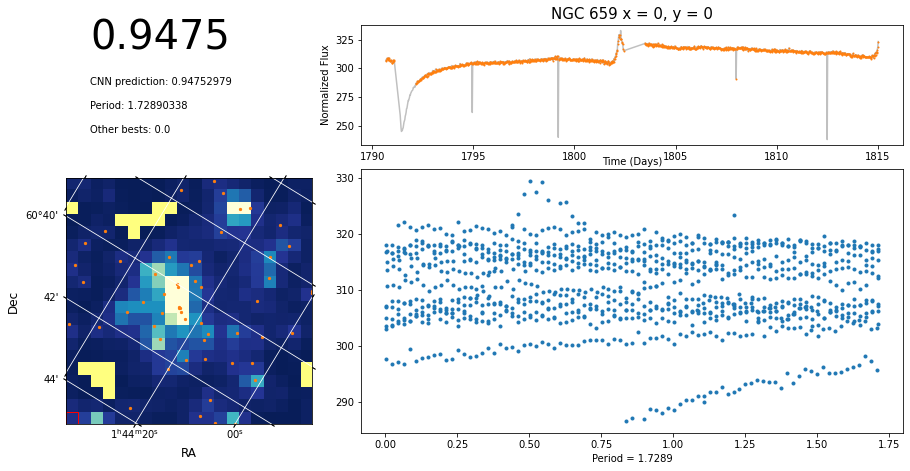

In [ ]:
Predict_max = np.zeros((size, size))

for l in range(np.shape(data_flux)[2]):
    for i in range(np.shape(data_flux)[1]):
#        try:
            flux_raw = bkgSubFlux[:,i,l]
            #eliminate outliers
            mean = np.mean(flux_raw)
            standard_deviation = np.std(flux_raw)
            distance_from_mean = abs(flux_raw - mean)
            max_deviations = 2
            not_outlier = distance_from_mean < max_deviations * standard_deviation
            flux_1d = flux_raw[not_outlier]
            
            #make CNN tests
            a_0 = 0.1
            r = 1.04
            length = 100
            geometric = [a_0 * r ** (n - 1) for n in range(1, length + 1)]
            period = np.array(geometric)
            t_0 = np.linspace(0,1,20)
            predict = np.zeros((len(period),len(t_0)))
            
            for j in range(len(period)):
                p = period[j]
                for k in range(len(t_0)):
                    t_pf = np.array((data_time + t_0[k] * p) % p)
                    t_pf = t_pf[not_outlier]
                    t = np.linspace(np.min(t_pf), np.max(t_pf), Sample_number)
                    f = interp1d(t_pf, flux_1d, kind='nearest')
                    flux = f(t)
                    #np.max(flux) - np.min(flux) np.percentile(flux, 100) - np.percentile(flux, 0)
                    flux /= (np.max(flux) - np.min(flux)) / 4
                    flux -= np.average(flux)
                    predict[j][k] = cnn.predict(flux.reshape((1, Sample_number, 1)))
            idx = np.where(predict == np.max(predict))
            
            ### repeat in the region near the best result of first step for higher precision
            period_ = np.linspace(period[idx[0][0]] / r ,period[idx[0][0]] * r,100)
            t_0 = np.linspace(0,1,20)
            predict = np.zeros((len(period_),len(t_0)))
    
            for j in range(len(period_)):
                p = period_[j]
                for k in range(len(t_0)):
                    t_pf = np.array((data_time + t_0[k] * p) % p )
                    t_pf = t_pf[not_outlier]
                    t = np.linspace(np.min(t_pf), np.max(t_pf), Sample_number)
                    f = interp1d(t_pf, flux_1d, kind='nearest')
                    flux = f(t)
                    flux /= (np.max(flux) - np.min(flux)) / 4
                    flux -= np.average(flux)
                    predict[j][k] = cnn.predict(flux.reshape((1, Sample_number, 1)))
                
            idx = np.where(predict == np.max(predict))
            p = period_[idx[0][0]]
            t_pf = np.array((data_time + t_0[idx[1][0]] * p)%p)
            t_pf = t_pf[not_outlier]
            Predict_max[i,l] = np.max(predict)
            #plot
            fig = plt.figure(figsize=(15, 7.5))
            ax1 = plt.subplot2grid((3, 3), (0, 0))
            ax2 = plt.subplot2grid((3, 3), (0, 1), colspan=2)
            ax3 = plt.subplot2grid((3, 3), (1, 0), rowspan=2, projection = wcs)
            ax4 = plt.subplot2grid((3, 3), (1, 1), colspan=2, rowspan=2)
            
            ax1.axis('off')
            ax1.text(0.1,0.8,'%.4f' % np.max(predict), fontsize=40)
            ax1.text(0.1,0.5,'CNN prediction: %.8f' % np.max(predict), fontsize=10)
            ax1.text(0.1,0.3,'Period: %.8f' % period_[idx[0][0]], fontsize=10)
            ax1.text(0.1,0.1,'Other bests: ' + str(0.5 * len(idx) - 1), fontsize=10)
            ax2.plot(data_time, flux_raw, color = 'silver')
            ax2.set_title(target_name + ' x = ' + str(l ) + ', y = ' + str(i ), fontsize = 15)
            ax2.set_ylabel('Normalized Flux')
            ax2.set_xlabel('Time (Days)', labelpad = -5)
            ax2.plot(data_time[not_outlier], flux_1d, ms = 2, marker = '.', c = 'C1', linestyle = '')
            ax3.imshow(firstImage, origin = 'lower', cmap = plt.cm.YlGnBu_r, vmax = np.percentile(firstImage, 98), 
                          vmin = np.percentile(firstImage, 5))
            ax3.grid(axis = 'both',color = 'white', ls = 'solid')
            nearbyLoc = wcs.all_world2pix(nearbyStars[0:],0)
            ax3.imshow(bkgAperture,cmap=cmap)
            ax3.scatter(nearbyLoc[0:, 0], nearbyLoc[0:, 1], s = 5, color = 'C1')
            ax3.set_xlim(-0.5,size - 0.5)
            ax3.set_ylim(-0.5,size - 0.5)
            ax3.set_xlabel('RA', fontsize = 12)
            ax3.set_ylabel('Dec', fontsize = 12)
            ax3.scatter(l,i, marker = 's', s = 160, facecolors='none', edgecolors='r')
            ax4.plot(t_pf,flux_1d,'.')
            ax4.set_xlabel('Period = %.4f' % period_[idx[0][0]])
            plt.show()
#        except:
#            print('error:' + 'x = ' + str(l + 1) + ', y = ' + str(i + 1))
#            pass